# ltu-ili optuna integration
Optuna Hyperparameter Search Tutorial for ltu-ili (NPE + Lampe)

This script performs hyperparameter optimization over neural density estimators using the ltu-ili package.
Only the NPE method is used, and we evaluate performance via the final validation log-probability.

Optuna is a lightweight hyperparameter optimization framework, particularly suited for black-box optimization.
It automates the search process over model architectures and training configurations. Here, we use Nondominated Sorting Genetic Algorithm (NSGA-II) to optimize the hyperparameters of the NPE model.

Based on an implementation by [Giuseppe Viterbo](https://github.com/vepe99)

In [1]:
import optuna
from optuna.trial import TrialState
import numpy as np
import torch
import matplotlib.pyplot as plt
import tarp

from ili.utils import Uniform, load_nde_lampe
from ili.dataloaders import TorchLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorSamples

## Load or simulate dataset
For demonstration purposes we create synthetic data

In [ ]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y


seed_sim = 12345
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])
x = torch.from_numpy(x).float()
theta = torch.from_numpy(theta).float()

# Split into train/test
num_samples = x.shape[0]
indices = np.random.permutation(num_samples)
split_idx = int(0.9 * num_samples)
train_idx, val_idx = indices[:split_idx], indices[split_idx:]
train_x, train_theta = x[train_idx], theta[train_idx]
val_x, val_theta = x[val_idx], theta[val_idx]

# TODO: NORMALIZE RUNNING MEAN AND STD

## Setup Optuna Objective

In [ ]:
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Sample hyperparameters
    model = trial.suggest_categorical("model", ["nsf", "maf", "gf"])

    # TODO: MAKE THIS INT
    hidden_features = trial.suggest_categorical(
        "hidden_features", [32, 64, 128])
    num_transforms = trial.suggest_categorical("num_transforms", [5, 10, 15])
    output_dim = trial.suggest_categorical("output_dim", [16, 32, 64])

    # Define prior from 0 to 1 for 3 parameters
    prior = Uniform(low=[0.0, 0.0, 0.0], high=[1.0, 1.0, 1.0], device=device)

    # Dummy embedding net
    from torch import nn
    embedding_net = nn.Sequential(
        nn.Linear(x.shape[1], output_dim),
        nn.ReLU(),
        nn.Linear(output_dim, output_dim),
    ).to(device)

    # Build NDE
    nets = [load_nde_lampe(
        model=model,
        hidden_features=hidden_features,
        num_transforms=num_transforms,
        embedding_net=embedding_net,
        x_normalize=False,
        device=device,
    )]

    train_args = dict(
        training_batch_size=32,
        learning_rate=5e-4,
        stop_after_epochs=15,
    )

    runner = InferenceRunner.load(
        backend="lampe",
        engine="NPE",
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args,
    )

    # Use fixed train/test split defined outside objective
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_x, train_theta),
        batch_size=32, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(val_x, val_theta),
        batch_size=32, shuffle=False
    )
    loader = TorchLoader(train_loader=train_loader, val_loader=val_loader)

    # Train
    posterior, summaries = runner(loader=loader)

    # TARP midpoint deviation
    sampler = PosteriorSamples(num_samples=500, sample_method='direct')
    samps = sampler(posterior, val_x)

    ecp, _ = tarp.get_tarp_coverage(
        samps, val_theta.cpu().numpy(),
        norm=True, bootstrap=True, num_bootstrap=100
    )
    tarp_val = torch.mean(torch.from_numpy(
        ecp[:, ecp.shape[1] // 2])).to(device)

    return summaries[0]['validation_log_probs'][-1], abs(tarp_val - 0.5)

## Run the study

In [4]:
study = optuna.create_study(
    directions=["maximize", "minimize"],
    study_name="ltu_ili_npe_tarp_study",
)
study.optimize(objective, n_trials=50, timeout=1800)

print("\nBest trial:")
best = study.best_trials[0]
print(f"  Log-prob: {best.values[0]:.4f}, TARP dev: {best.values[1]:.4f}")
print("  Params:")
for k, v in best.params.items():
    print(f"    {k}: {v}")

[I 2025-05-27 14:21:45,364] A new study created in memory with name: ltu_ili_npe_tarp_study
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.
66 epochs [00:03, 16.76 epochs/s, loss=-3.77, loss_val=-1.94]  
INFO:root:It took 4.370271921157837 seconds to train models.
100%|██████████| 100/100 [00:00<00:00, 2337.71it/s]
[I 2025-05-27 14:21:51,788] Trial 0 finished with values: [1.94268798828125, 0.10249999999999998] and parameters: {'model': 'gf', 'hidden_features': 64, 'num_transforms': 10, 'output_dim': 16}.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.
58 epochs [00:05,  9.77 epochs/s, loss=-4.22, loss_val=-1.91] 
INFO:root:It took 5.949107885360718 seconds to train models.
100%|██████████| 100/100 [00:00<00:00, 2263.62it/s]
[I 2025-05-27 14:21:59,124] Trial 1 finished with values: [1.9123971939086915, 0.15450000000000003] and parameters: {'model': 'nsf', 'hidden_features': 128, 'num_transforms': 15, 'output_dim': 32}.
INFO:root:MODEL INFERENCE


Best trial:
  Log-prob: 2.9388, TARP dev: 0.2120
  Params:
    model: gf
    hidden_features: 32
    num_transforms: 10
    output_dim: 32


## Plot the Pareto front

(0.0, 0.23065000000000002)

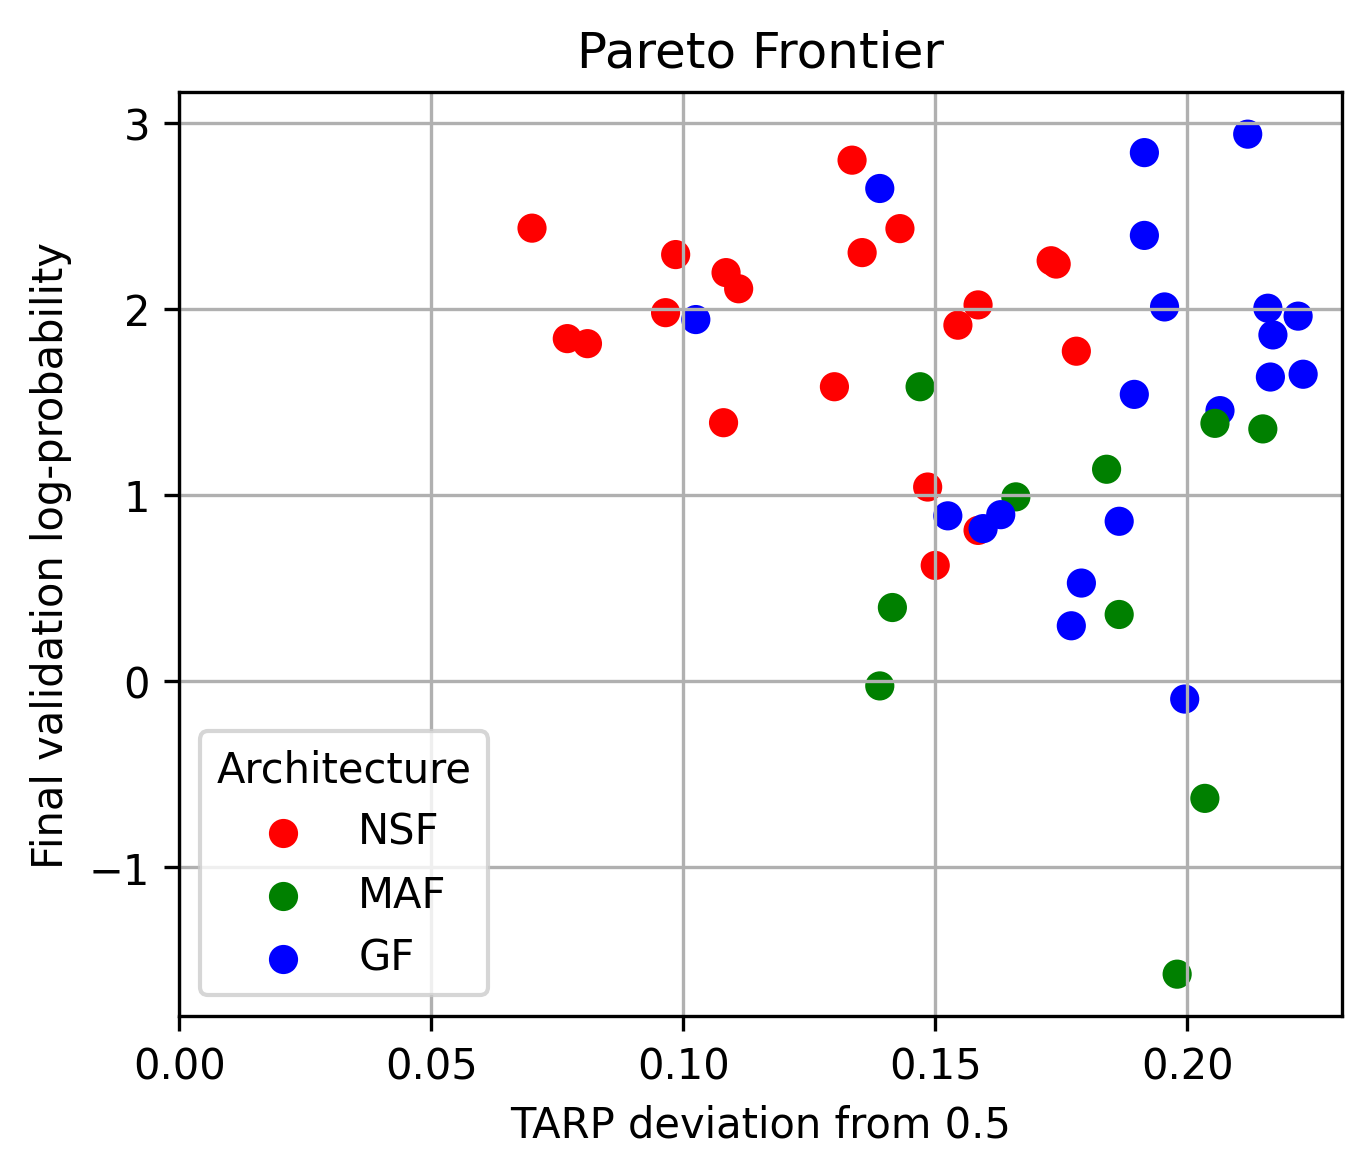

In [5]:
log_probs = [t.values[0] for t in study.trials if t.values is not None]
tarp_devs = [t.values[1] for t in study.trials if t.values is not None]

f, ax = plt.subplots(figsize=(5, 4), dpi=300)
model_colors = {'nsf': 'red', 'maf': 'green', 'gf': 'blue'}
colors = [model_colors.get(t.params.get("model", ""), "gray")
          for t in study.trials if t.values is not None]
for model, color in model_colors.items():
    ax.scatter([], [], color=color, label=model.upper())
ax.scatter(tarp_devs, log_probs, c=colors)

ax.set(
    xlabel="TARP deviation from 0.5",
    ylabel="Final validation log-probability",
    title="Pareto Frontier",
)
ax.grid(True)
ax.legend(title='Architecture', loc='lower left')
ax.set_xlim(0)